We use this ready-made piece of code to draw a computational graph composed of MLP neural network.

In [ ]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

- **`Tensor` class**: This class is designed to facilitate the representation and manipulation of weights and biases in a neural network. The primary goal of this class is to manage its children and enable the calculation of their gradients within a computational graph.

  - **`__init__` method**: Initializes the tensor with its initial value, which is typically a scalar in this project, along with its children, the last operation applied, and the node's gradient.
  - **`__repr__` method**: Controls how instances of the `Tensor` class are displayed when printed.
  - **Operator methods**: Methods such as `__mul__`, `__add__`, `__pow__`, and `__sub__` are used to perform various operations on tensors, like multiplication, addition, exponentiation, and subtraction. They also handle the computation of gradients for each operation.
  - **`backward` method**: Performs a reverse order traversal of the computational graph from top to bottom, calculating and updating the gradients for each node.

- **`F` class**: This class includes methods for applying activation functions such as the hyperbolic tangent function. These methods not only compute the function's value but also calculate the corresponding gradients.


In [ ]:
import random
import math
from math import exp

class Tensor:
    def __init__(self, value, label='', children=(), operator=None):
        self.value = value
        self.children = set(children)
        self.operator = operator
        self.grad = 0
        self._backward = lambda: None
        self.label = label

    def __repr__(self) -> str:
        return f"Tensor(value={self.value})"

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        out = Tensor(self.value * other.value, children= (self, other), operator='*')

        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad

        out._backward = backward

        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)

        out = Tensor(self.value + other.value, children=(self, other), operator='+')

        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = backward

        return out

    def __pow__(self, other):
        input_value = self.value
        output_value = math.pow(input_value, other)

        out = Tensor(output_value, children=(self,), operator='pow')

        def backward():
            self.grad += other * math.pow(self.value, other - 1) * out.grad

        out._backward = backward

        return out

    def __sub__(self, other):
        return self + -other

    def backward(self):
        topo_sort = []
        visited_set = set()
        def build_topo(v):
            for child in v.children:
                if child not in visited_set:
                    visited_set.add(v)
                    build_topo(child)
            topo_sort.append(v)
        build_topo(self)

        for i in reversed(topo_sort):
            i._backward()


class F:
    @staticmethod
    def tan_hyperbolic(x) -> Tensor:
        x = x if isinstance(x, Tensor) else Tensor(x)

        # out=Tensor((exp(x.value)-exp(-x.value))/(exp(x.value)+exp(-x.value)), children=(x, ), operator='tanh')
        out=Tensor(math.tanh(x.value),children=(x, ), operator='tanh')
        def backward():
            x.grad += (1 - out.value ** 2) * out.grad

        out._backward = backward

        return out

In this section, the structure of a Multi-Layer Perceptron (MLP) neural network is implemented, which consists of several different layers. This section includes three main classes: the `Neuron` class for the network's neurons, the `Layer` class for the network's layers, and the `MLP` class for the multi-layer neural network.

- **`Neuron` class:**
  - **`__init__` method:** This method is used to create a neuron with random weights and a random bias.
  - **`forward` method:** This method takes inputs as the neuron's inputs and calculates its output using the hyperbolic tangent activation function.
  - **`__call__` method:** This method is used to invoke the neuron as a function.
  - **`parameters` method:** This method returns a list of the neuron's weights and bias.

- **`Layer` class:**
  - **`__init__` method:** This method is used to create a layer of neurons with the given number of inputs and outputs.
  - **`forward` method:** This method takes inputs as the layer's inputs and calculates its output using all the neurons in the layer.
  - **`__call__` method:** This method is used to invoke the layer as a function.
  - **`parameters` method:** This method returns a list of the weights and biases of all the neurons in the layer.

- **`MLP` class:**
  - **`__init__` method:** This method is used to create a multi-layer neural network with the given number of inputs and the size of each layer.
  - **`forward` method:** This method takes inputs as the network's inputs and calculates the network's output using all the layers in the network.
  - **`__call__` method:** This method is used to invoke the network as a function.
  - **`parameters` method:** This method returns a list of the weights and biases of all the neurons in all the layers of the network.


In [ ]:
class Neuron:

  def __init__(self, input_size):
      self.weights = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]
      self.bias = Tensor(random.uniform(-1, 1))

  def forward(self, x):
      _res = [w_i * x_i for w_i, x_i in zip(self.weights, x)]
      res = Tensor(0)
      for r in _res:
          res += r
      return F.tan_hyperbolic(res + self.bias)

  def __call__(self, x):
      return self.forward(x)

  def parameters(self):
      return self.weights + [self.bias]

In [ ]:
class Layer:

    def __init__(self, input_size, output_size):
        self.neurons = [Neuron(input_size) for _ in range(output_size)]

    def forward(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out)==1 else out

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        params = []
        for neuron in self.neurons:
            for param in neuron.parameters():
                params.append(param)

        return params

In [ ]:
class MLP:

  def __init__(self, input_size, layer_sizes):
      layers_total = [input_size] + layer_sizes
      self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
      for layer in self.layers:
          x = layer(x)
      return x

  def __call__(self, x):
      return self.forward(x)

  def parameters(self):
      params = []
      for layer in self.layers:
          for param in layer.parameters():
              params.append(param)

      return params

In this section, a function for calculating the network's loss is implemented, which takes inputs named `y_hats` and `real_y`, representing the network's predictions and the actual values, respectively. This function can then calculate the overall network error using the squared error between the network's predictions and the actual values.

- **`compute_loss` function:**
  - **Parameters:** The inputs `y_hats` and `real_y` represent the network's predictions and the actual values, respectively.
  - **Functionality:** This function iterates through the lists `y_hats` and `real_y`, and for each pair of predictions and actual values, it calculates the squared error between them. It then sums these errors to compute the overall network error.
  - **Gradient Calculation:** Finally, this function initializes the gradient associated with the overall network error to 1, which is then used for backward propagation.


In [ ]:
def compute_loss(y_hats, real_y):
    total_loss = Tensor(0)
    for y_hat, y in zip(y_hats, real_y):
        loss = (y_hat - y) ** 2
        total_loss += loss
    # backward propagation to compute gradients based on loss gradient
    total_loss.grad = 1

    return total_loss

**`Optimizer` class:**

- **`__init__` method:** This method is used to create an optimizer with inputs including a list of the network's weights and biases, and the learning rate.
- **`zero_grad` method:** This method resets the gradients of all the network's weights and biases to zero, preparing them for the calculation of new gradients.
- **`step` method:** This method updates the network's weights and biases by subtracting the calculated gradients from their current values using the learning rate, in order to improve the network's performance.


In [ ]:
class Optimizer:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        for param in self.parameters:
            param.grad = 0

    def step(self):
        for param in self.parameters:
            param.value -= self.lr * param.grad

In this code snippet, a Multi-Layer Perceptron (MLP) neural network is constructed using the `MLP` class. An `Optimizer` is then defined to update the weights and biases. During each training cycle, the inputs (`x`) are fed into the network, and the model's outputs (`y_hats`) are calculated for each sample. The loss is then computed using the `compute_loss` function for the predicted and actual values. The loss for the model is calculated, and the gradients are computed using backward propagation. Finally, the optimizer is called to update the weights and biases (`optim.step`), and the information for each training cycle (such as the cycle number and the loss value) is printed.


In [ ]:
n_epochs = 500

x = [[1.0, 2.0, 3.0],
     [2.0, 3.0, 4.0],
     [1.0, 2.0, 4.0],
     [2.0, 3.0, -1.0]]
y = [1.0,
     -1.0,
     1.0,
     1.0]

layer_sizes = [2, 3, 1]
mlp = MLP(input_size=3, layer_sizes=layer_sizes)
optim = Optimizer(parameters=mlp.parameters(), lr=0.01)

for i in range(n_epochs):

    y_hats = [mlp(_x) for _x in x]

    loss = compute_loss(y_hats, y)
    optim.zero_grad()
    loss.backward()

    optim.step()

    print(f'epoch {i+1}, LOSS_value: {loss.value}')

epoch 1, LOSS_value: 5.475228921301806
epoch 2, LOSS_value: 4.799252266875589
epoch 3, LOSS_value: 4.244861045098559
epoch 4, LOSS_value: 3.833638781292248
epoch 5, LOSS_value: 3.549504141876875
epoch 6, LOSS_value: 3.359778305763335
epoch 7, LOSS_value: 3.233452652434816
epoch 8, LOSS_value: 3.147742754938664
epoch 9, LOSS_value: 3.0876641153779465
epoch 10, LOSS_value: 3.0437835149449417
epoch 11, LOSS_value: 3.010227953695776
epoch 12, LOSS_value: 2.9833283151500956
epoch 13, LOSS_value: 2.9607734692856154
epoch 14, LOSS_value: 2.9410966042907427
epoch 15, LOSS_value: 2.923362953955556
epoch 16, LOSS_value: 2.906977164325788
epoch 17, LOSS_value: 2.891562033941934
epoch 18, LOSS_value: 2.876880626060918
epoch 19, LOSS_value: 2.8627854532692396
epoch 20, LOSS_value: 2.8491850653590154
epoch 21, LOSS_value: 2.8360221160097385
epoch 22, LOSS_value: 2.823259127361862
epoch 23, LOSS_value: 2.8108694419233133
epoch 24, LOSS_value: 2.798831646094699
epoch 25, LOSS_value: 2.7871262776765957

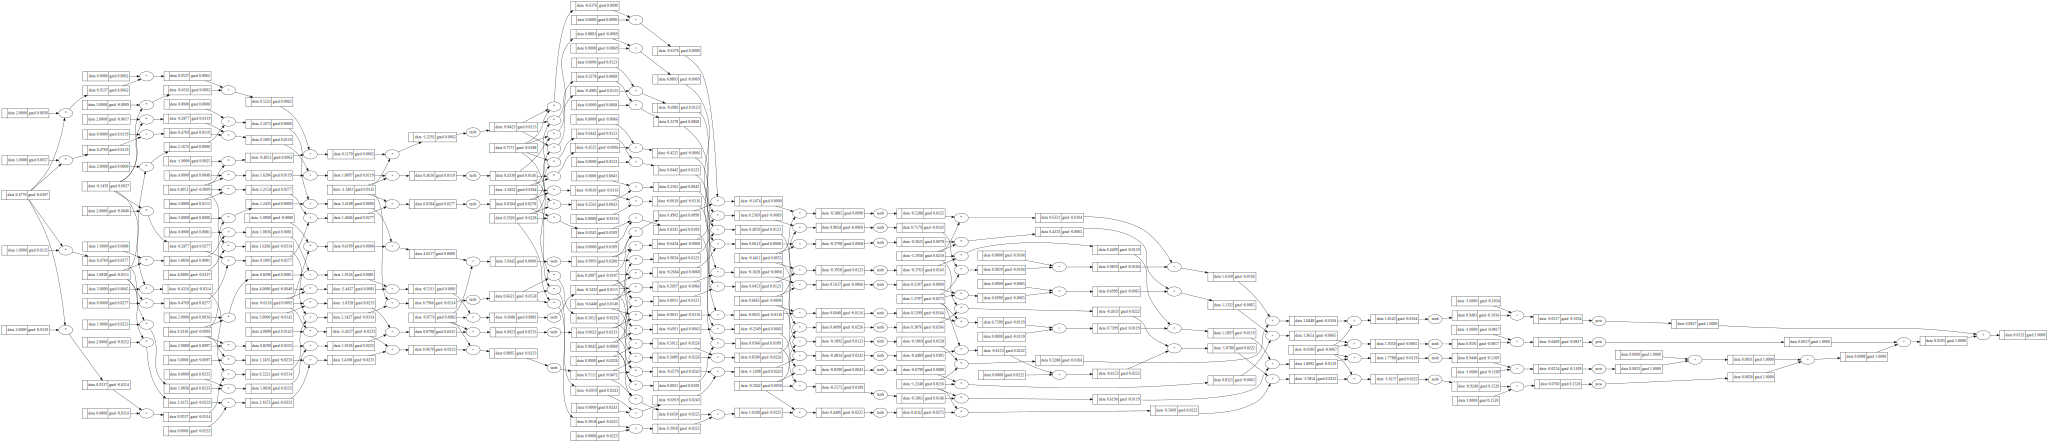

In [ ]:
draw_dot(loss)

In [ ]:
for y_pred in y_hats:
    print(y_pred.value)

0.944570160027212
-0.9240041098622853
0.9591393897076311
0.9482862514172066
